In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

from sklearn.preprocessing import LabelEncoder
from mlxtend.feature_selection import SequentialFeatureSelector

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

### Definition of data preparation functions

In [2]:
def clear_data(main_data):
    # set appropriate data types
    int_time_to_str = lambda x: x[:4] + '-' + x[4:6] + '-' + x[6:8] + ' ' + x[8:10] + ':' + x[10:12] + ':' + x[12:]

    main_data["date_account_created"] = main_data["date_account_created"].astype("datetime64[ns]")
    main_data["timestamp_first_active"] = main_data["timestamp_first_active"].astype(str) \
                                                                             .apply(int_time_to_str) \
                                                                             .astype("datetime64[ns]")
    main_data["date_first_booking"] = main_data["date_first_booking"].astype("datetime64[ns]")
    main_data["signup_flow"] = main_data["signup_flow"].astype(str)
    
    # Dealing with NaN values and clearing dataset
    
    main_data = main_data[(main_data["age"] < 100) | (main_data["age"].isnull())]
    main_data = main_data.dropna(subset=["first_affiliate_tracked"])
    main_data = main_data.drop("date_first_booking", axis=1)
    
    ages = main_data.groupby(["gender"]).mean().reset_index()
    ages = ages.rename(columns={"age": "mean_age"})
    ages["mean_age"] = ages["mean_age"].round()
    main_data = main_data.merge(ages, on=["gender"])
    main_data["age"] = main_data["age"].fillna(main_data["mean_age"])
    main_data = main_data.drop("mean_age", axis=1)
    
    return main_data

def encode_data(data):
    df = data.drop(["id",
                    "date_account_created",
                    "timestamp_first_active",
                    "language",
                    "affiliate_channel",
                    "first_browser",
                    "first_affiliate_tracked",
                    "signup_flow"], axis=1)

    df = pd.get_dummies(df, columns=["gender", 
                                     "affiliate_provider", 
                                     "first_device_type",
                                     "signup_method",
                                     "signup_app"])
    
    return df

### Definition of confusion matrix plot function

In [3]:
def conf_matrix(y_test, y_pred):
    
    cm = confusion_matrix(y_test, y_pred)

    class_names = ['NDF', 'US', 'other', 'CA', 'FR', 'ES', 'GB', 'IT', 'PT', 'NL', 'DE', 'AU']

    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(16, 14))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_names, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(class_names, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('Refined Confusion Matrix', fontsize=20)

    plt.show()

### Definition of metrics evaluation function

In [41]:
def evaluate_metrics(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")

    print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}")

    conf_matrix(y_test, y_pred)

## Data preparation

In [4]:
data = pd.read_csv("data/train_users_processed.csv")
test_data = pd.read_csv("data/test_users.csv")

In [5]:
df = encode_data(data)

test_data = clear_data(test_data)
test_df = encode_data(test_data)

cat_type = CategoricalDtype(df["country_destination"].unique(), ordered=True)
df["country_destination"] = df["country_destination"].astype(cat_type).cat.codes

In [6]:
X = df.drop(["country_destination"], axis=1)
Y = df["country_destination"]

cols_not_in_test = set(X).difference(set(test_df.columns))
cols_not_in_X = set(test_df).difference(set(X.columns))

# dealing with missing unique values in both dataframes

for col in cols_not_in_test:
    test_df[col] = 0
    
for col in cols_not_in_X:
    X[col] = 0
    
test_df.columns = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### Base tree model training

In [8]:
tree = DecisionTreeClassifier(max_depth=8, criterion="entropy")
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

/home/uladzimir/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6439909297052154
Precision: 0.23928882583819786
Recall: 0.15902460310549507


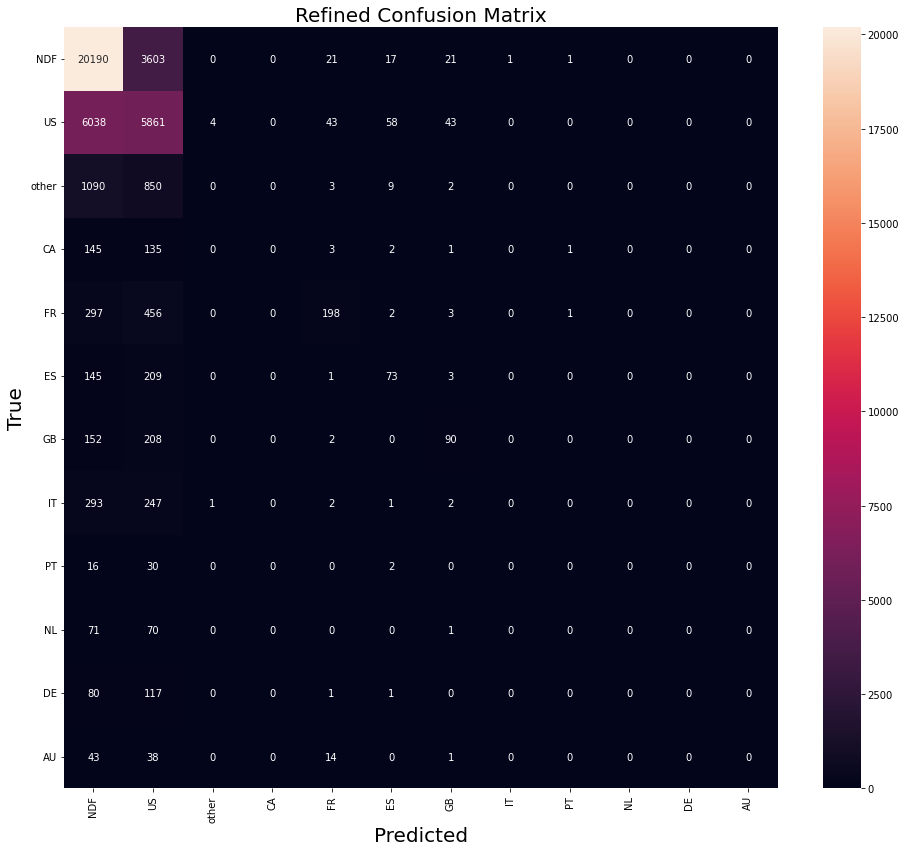

In [42]:
evaluate_metrics(tree, X_test, y_test)

### Tree model with random oversampling

In [25]:
strategy_over = {3: 25000,
                 4: 25000,
                 5: 25000,
                 6: 25000,
                 7: 25000,
                 8: 25000,
                 9: 25000,
                 10: 25000,
                 11: 25000}

ros = RandomOverSampler(sampling_strategy=strategy_over, random_state=0)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train)

In [16]:
tree_os = DecisionTreeClassifier(max_depth=8, criterion="entropy")
tree_os.fit(X_train_os, y_train_os)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

/home/uladzimir/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5975910077292566
Precision: 0.20354275506685762
Recall: 0.1777026003481299


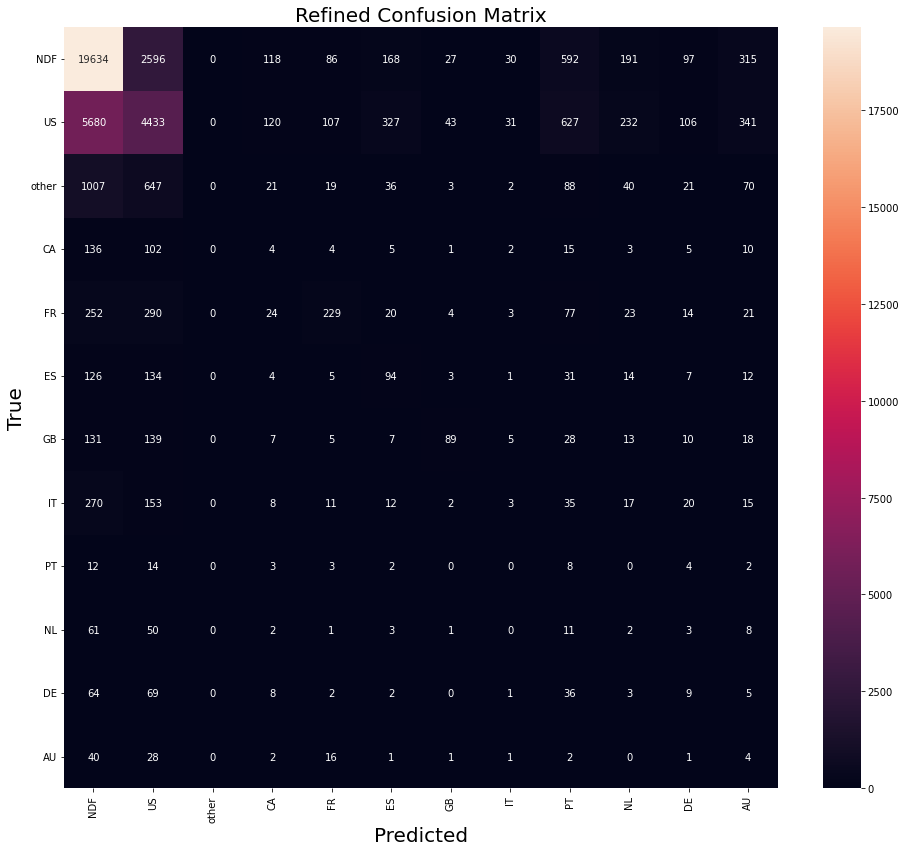

In [46]:
evaluate_metrics(tree_os, X_test, y_test)

### Tree model with undersampling

In [18]:
strategy_under = {0: 50000,
                  1: 30000}

rus = RandomUnderSampler(sampling_strategy=strategy_under, random_state=0)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

In [19]:
tree_us = DecisionTreeClassifier(max_depth=8, criterion="entropy")
tree_us.fit(X_train_us, y_train_us)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

/home/uladzimir/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6407236729817375
Precision: 0.2509945317405608
Recall: 0.1665271264268916


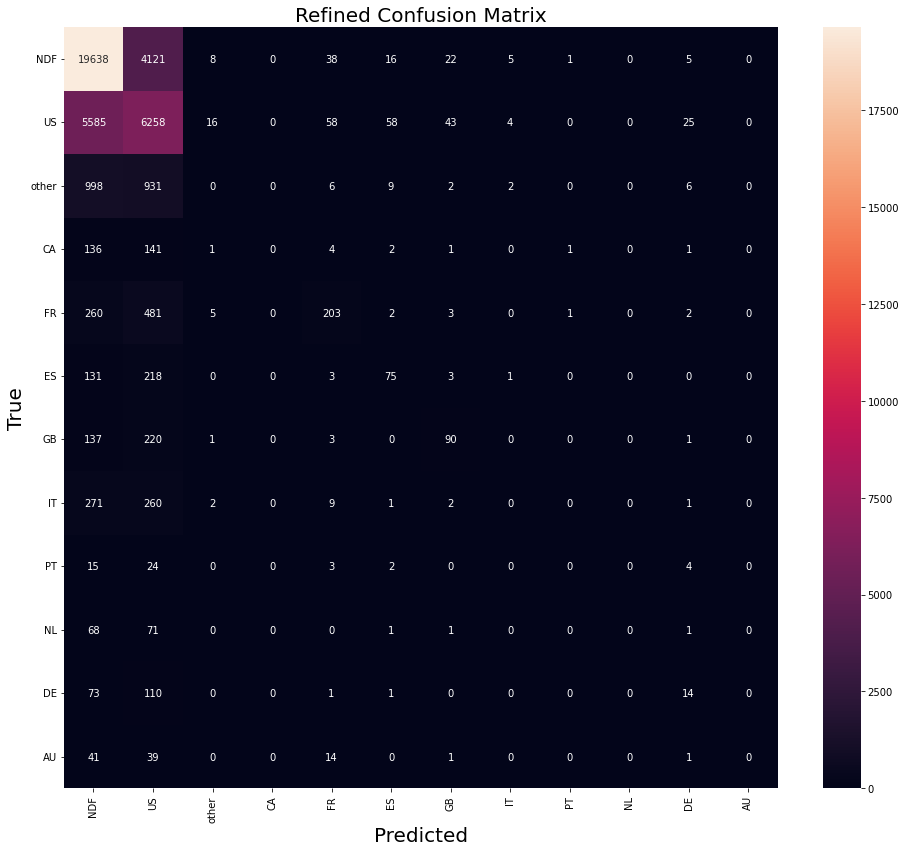

In [47]:
evaluate_metrics(tree_us, X_test, y_test)

### Tree model with oversampling using SMOTE

In [22]:
strategy_smote = {3: 25000,
                  4: 25000,
                  5: 25000,
                  6: 25000,
                  7: 25000,
                  8: 25000,
                  9: 25000,
                  10: 25000,
                  11: 25000}

smote = SMOTENC(categorical_features=list(range(1, len(X.columns))),
                sampling_strategy=strategy_smote)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [23]:
tree_sm = DecisionTreeClassifier(max_depth=8, criterion="entropy")
tree_sm.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

Accuracy: 0.612976373345037
Precision: 0.2161221740080946
Recall: 0.17814488901121908


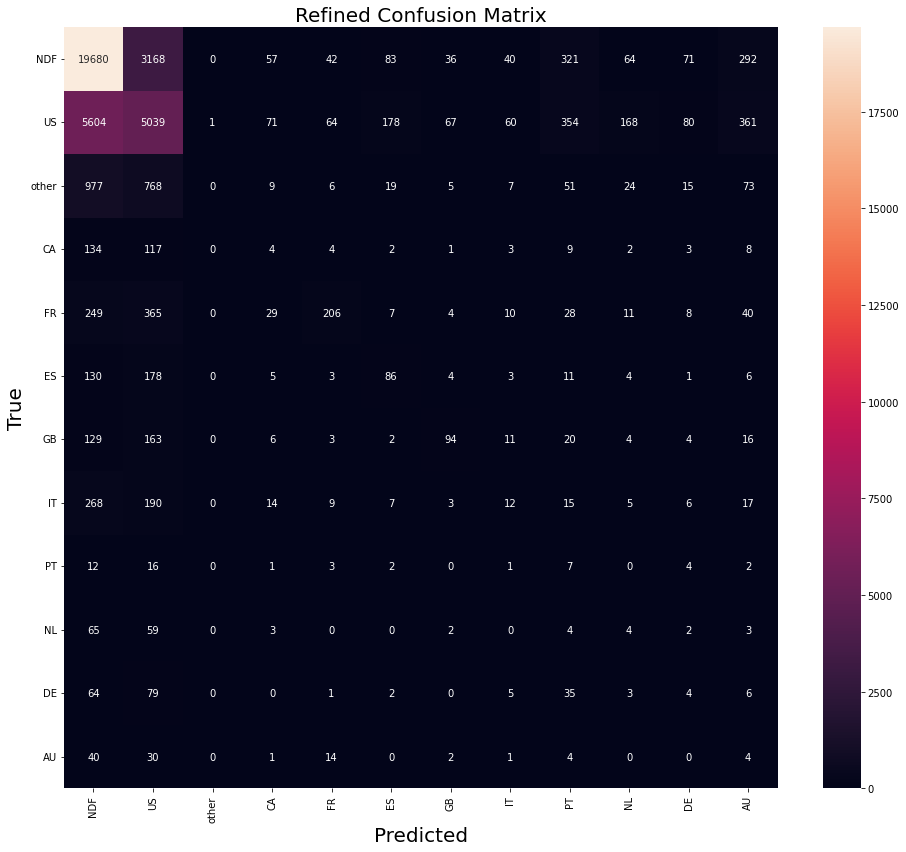

In [48]:
evaluate_metrics(tree_sm, X_test, y_test)

### Tree model with undersampling using NearMiss

In [26]:
strategy_nearmiss = {0: 50000,
                     1: 30000}

nm = NearMiss(sampling_strategy=strategy_nearmiss)
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

In [28]:
tree_nm = DecisionTreeClassifier(max_depth=8, criterion="entropy")
tree_nm.fit(X_train_nm, y_train_nm)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

/home/uladzimir/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4779703996293858
Precision: 0.18036520694101912
Recall: 0.15279898319250984


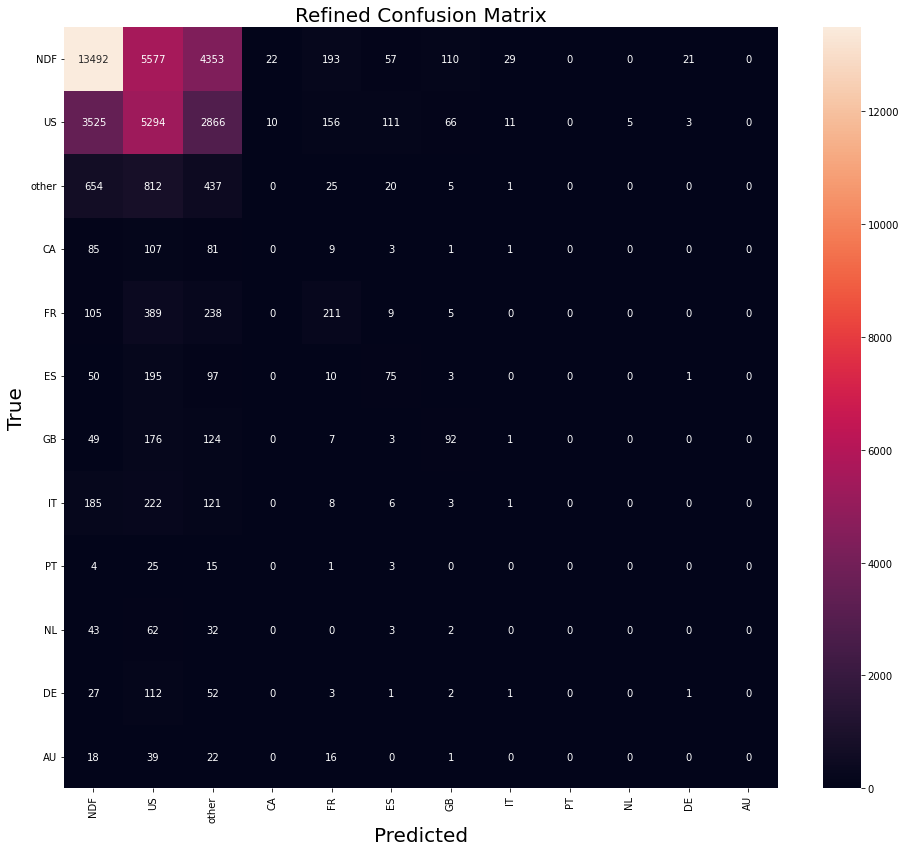

In [51]:
evaluate_metrics(tree_nm, X_test, y_test)

### Tree OnevsRest model training

In [39]:
tree_ovr = OneVsRestClassifier(DecisionTreeClassifier(max_depth=8, criterion="entropy"))
tree_ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=8))

/home/uladzimir/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6430400117036061
Precision: 0.2453030082397142
Recall: 0.15826482157922483


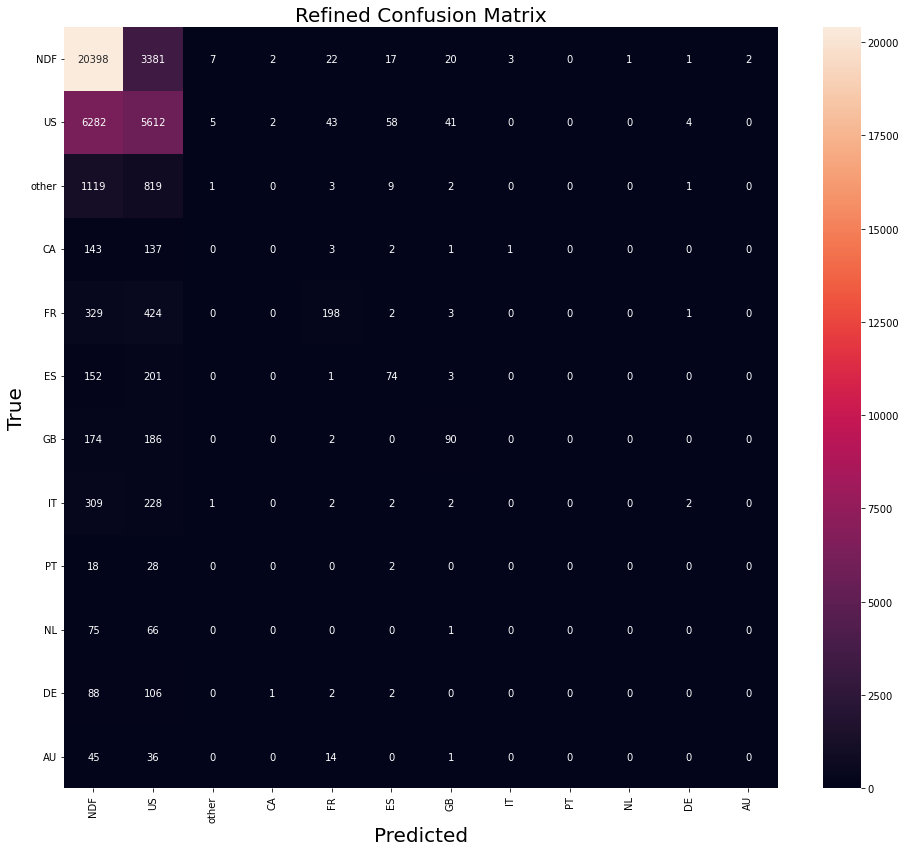

In [52]:
evaluate_metrics(tree_ovr, X_test, y_test)

### Random forest model training

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
forest = RandomForestClassifier(n_estimators=100,
                                max_depth=8,
                                criterion="entropy")
forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8)

/home/uladzimir/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6193889742276839
Precision: 0.09615068469937466
Recall: 0.10093030414421189


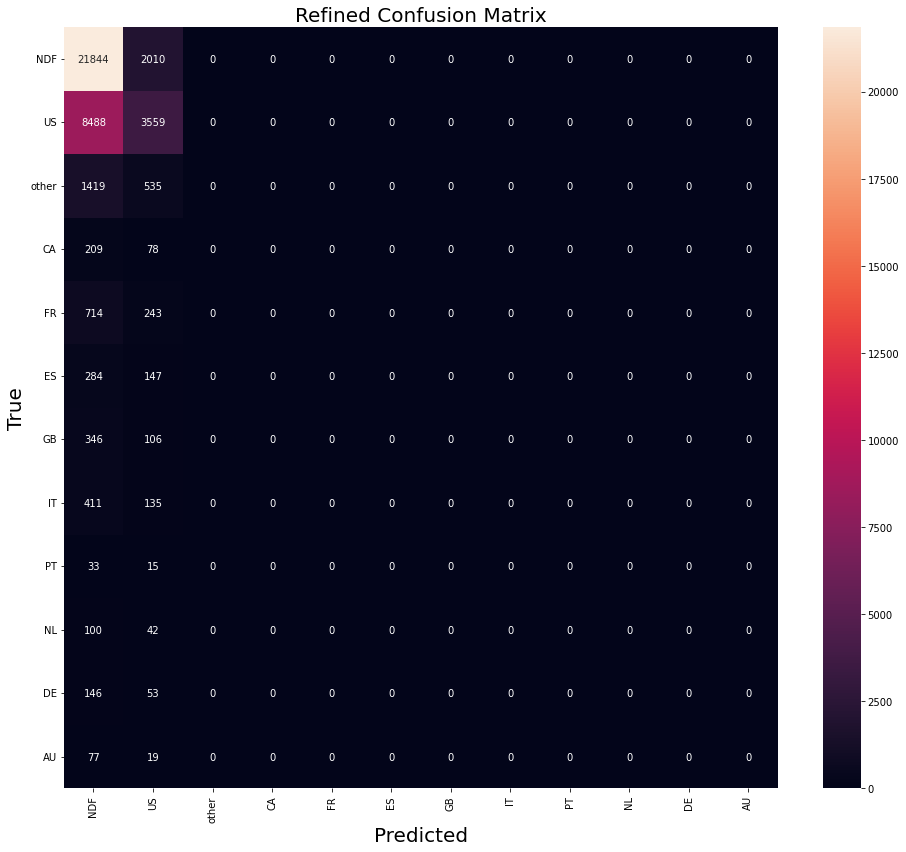

In [53]:
evaluate_metrics(forest, X_test, y_test)

### XGBoost model training

In [36]:
from xgboost import XGBClassifier

In [37]:
xgb_model = XGBClassifier(n_estimators=30, max_depth=8)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=30, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, ...)

/home/uladzimir/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6434788969351182
Precision: 0.25757986793770044
Recall: 0.15963342708854902


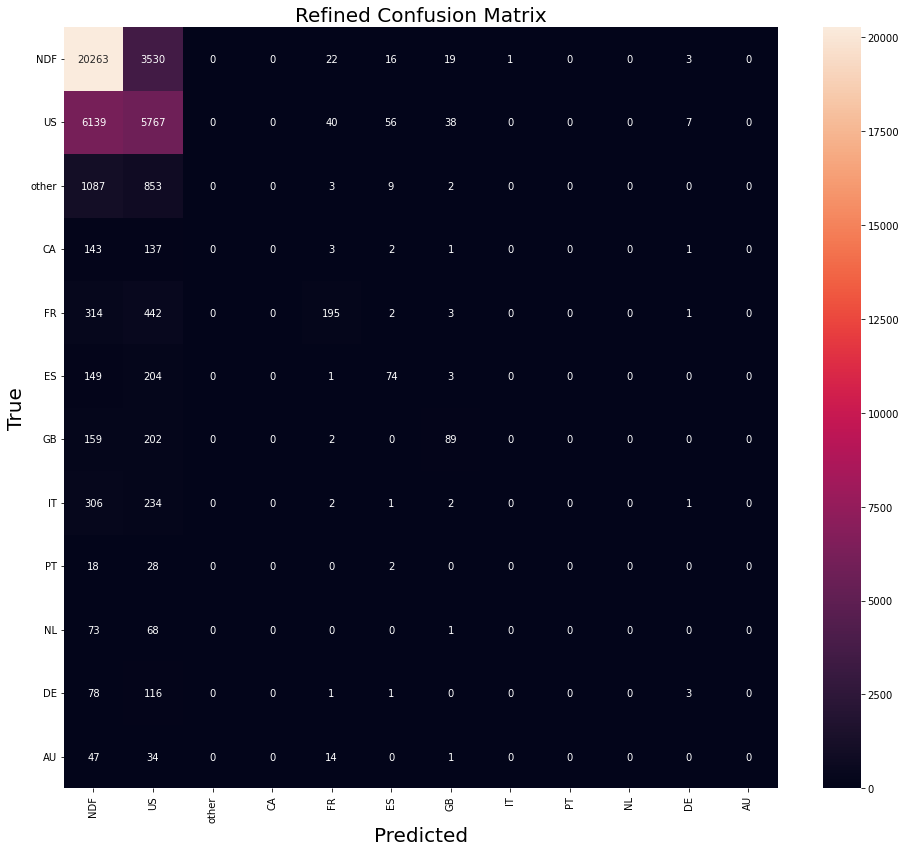

In [54]:
evaluate_metrics(xgb_model, X_test, y_test)

### Run model on test data

In [31]:
y_test_pred = tree.predict(test_df)
y_test_pred = pd.Series(y_test_pred)
categories = cat_type.categories

y_test_pred = y_test_pred.apply(lambda x: categories[x])

In [32]:
submission = pd.DataFrame({"id": test_data["id"], "country": y_test_pred})

In [33]:
submission.to_csv("submissions/submission_0.csv")